# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [2]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



#Training the models with Attention

In [5]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention_LD = LuongDotAttention()
model_attention, encoder_lstm_LD, decoder_lstm_LD, decoder_dense_LD = build_attention_model(attention_LD, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 169s 2s/step - loss: 2.9641 - accuracy: 0.0534 - val_loss: 2.9479 - val_accuracy: 0.0522
Epoch 2/150
18/18 [==============================] - 5s 267ms/step - loss: 2.9455 - accuracy: 0.0542 - val_loss: 2.9450 - val_accuracy: 0.0539
Epoch 3/150
18/18 [==============================] - 5s 267ms/step - loss: 2.9428 - accuracy: 0.0593 - val_loss: 2.9420 - val_accuracy: 0.0622
Epoch 4/150
18/18 [==============================] - 5s 267ms/step - loss: 2.9382 - accuracy: 0.0664 - val_loss: 2.9358 - val_accuracy: 0.0676
Epoch 5/150
18/18 [==============================] - 5s 272ms/step - loss: 2.9298 - accuracy: 0.0722 - val_loss: 2.9268 - val_accuracy: 0.0742
Epoch 6/150
18/18 [==============================] - 5s 259ms/step - loss: 2.9207 - accuracy: 0.0783 - val_loss: 2.9186 - val_accuracy: 0.0802
Epoch 7/150
18/18 [==============================] - 5s 259ms/step - loss: 2.9085 - accuracy: 0.0837 - val_loss: 2.9081 - val_accuracy: 0.0865


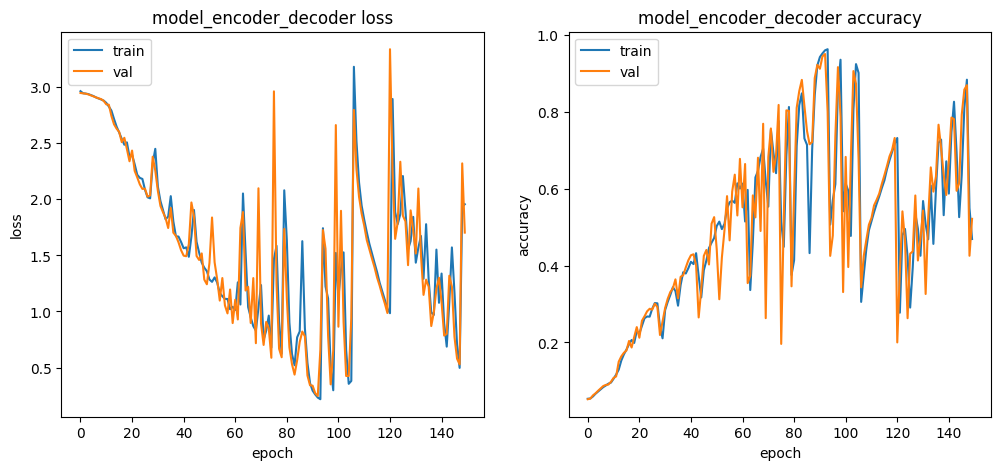

In [6]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_query = tf.keras.layers.Dense(units)
    self.W_values = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # Expand dimensions to prepare for addition
    query_with_time_axis = tf.expand_dims(query, 1)

    # Calculate BahdanauAttention attention scores
    score = self.V(tf.nn.tanh(
    self.W_query(query_with_time_axis) + self.W_values(values)))

    attention_weights = tf.nn.softmax(score, axis=1)

    # Calculate context vector
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [17]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention_B = BahdanauAttention(rnn_units)
model_attention, encoder_lstm_B, decoder_lstm_B, decoder_dense_B = build_attention_model(attention_B, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 234s 3s/step - loss: 2.9663 - accuracy: 0.0532 - val_loss: 2.9496 - val_accuracy: 0.0557
Epoch 2/150
18/18 [==============================] - 14s 787ms/step - loss: 2.9457 - accuracy: 0.0554 - val_loss: 2.9425 - val_accuracy: 0.0658
Epoch 3/150
18/18 [==============================] - 14s 799ms/step - loss: 2.9395 - accuracy: 0.0647 - val_loss: 2.9361 - val_accuracy: 0.0660
Epoch 4/150
18/18 [==============================] - 14s 791ms/step - loss: 2.9318 - accuracy: 0.0707 - val_loss: 2.9268 - val_accuracy: 0.0750
Epoch 5/150
18/18 [==============================] - 14s 775ms/step - loss: 2.9229 - accuracy: 0.0770 - val_loss: 2.9175 - val_accuracy: 0.0804
Epoch 6/150
18/18 [==============================] - 14s 776ms/step - loss: 2.9141 - accuracy: 0.0819 - val_loss: 2.9095 - val_accuracy: 0.0851
Epoch 7/150
18/18 [==============================] - 14s 781ms/step - loss: 2.9053 - accuracy: 0.0868 - val_loss: 2.9008 - val_accuracy: 0

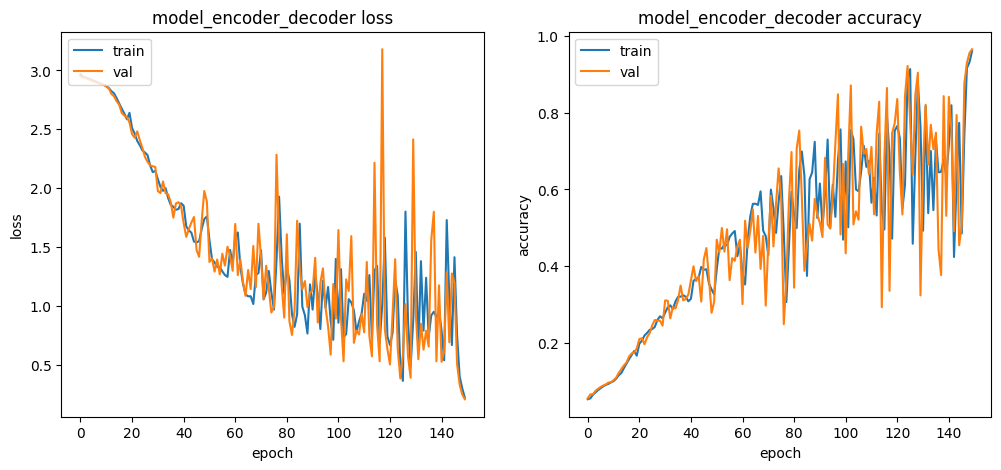

In [18]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

In [4]:
class LuongGeneralAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W_query = tf.keras.layers.Dense(units)
        self.W_values = tf.keras.layers.Dense(units)

    def call(self, query, values):
        # Expand dimensions to prepare for addition
        query_with_time_axis = tf.expand_dims(query, 1)

        # Calculate LuongGeneralAttention scores
        score = tf.transpose(tf.matmul(self.W_query(query_with_time_axis),
                                       tf.transpose(self.W_values(values), perm=[0, 2, 1])), perm=[0, 2, 1])

        attention_weights = tf.nn.softmax(score, axis=1)

        # Calculate context vector
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [5]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention_LDG = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm_LDG, decoder_lstm_LDG, decoder_dense_LDG  = build_attention_model(attention_LDG, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 195s 3s/step - loss: 2.9626 - accuracy: 0.0549 - val_loss: 2.9477 - val_accuracy: 0.0544
Epoch 2/150
18/18 [==============================] - 13s 699ms/step - loss: 2.9445 - accuracy: 0.0571 - val_loss: 2.9428 - val_accuracy: 0.0542
Epoch 3/150
18/18 [==============================] - 13s 701ms/step - loss: 2.9396 - accuracy: 0.0651 - val_loss: 2.9355 - val_accuracy: 0.0686
Epoch 4/150
18/18 [==============================] - 13s 701ms/step - loss: 2.9306 - accuracy: 0.0731 - val_loss: 2.9251 - val_accuracy: 0.0727
Epoch 5/150
18/18 [==============================] - 13s 702ms/step - loss: 2.9223 - accuracy: 0.0786 - val_loss: 2.9166 - val_accuracy: 0.0810
Epoch 6/150
18/18 [==============================] - 12s 692ms/step - loss: 2.9139 - accuracy: 0.0830 - val_loss: 2.9069 - val_accuracy: 0.0882
Epoch 7/150
18/18 [==============================] - 13s 704ms/step - loss: 2.9027 - accuracy: 0.0881 - val_loss: 2.8970 - val_accuracy: 0

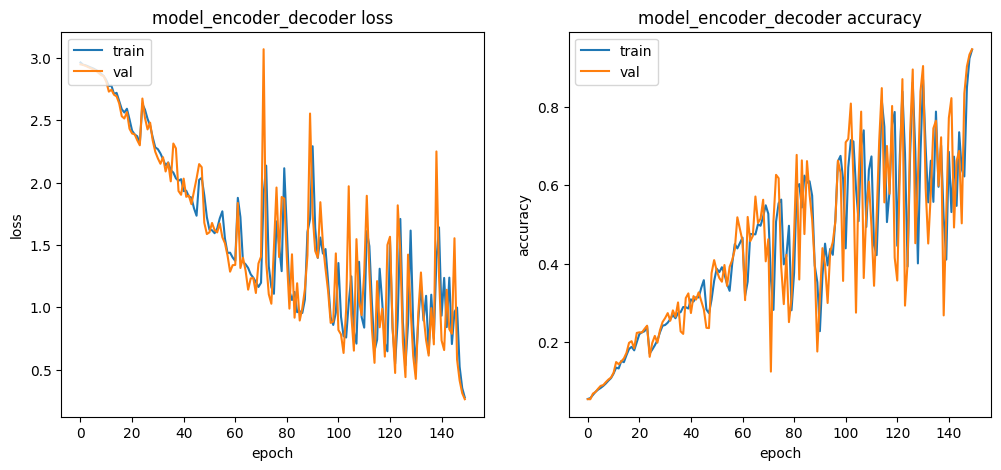

In [6]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

### Weight Visualization


In [7]:
import matplotlib.ticker as ticker

def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  # Given in build_attention_model
  for i in range(n_timesteps_in):

      # Pay attention!
      # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # create the context vector by applying attention to
      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[i] = attention_weights.numpy()

      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output
      # save the current prediction
      # we will concatenate all predictions later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])

  return seq_in, seq_out, attention_plot


def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # add labels
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)



<ipython-input-19-8a329c8a4881>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-19-8a329c8a4881>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


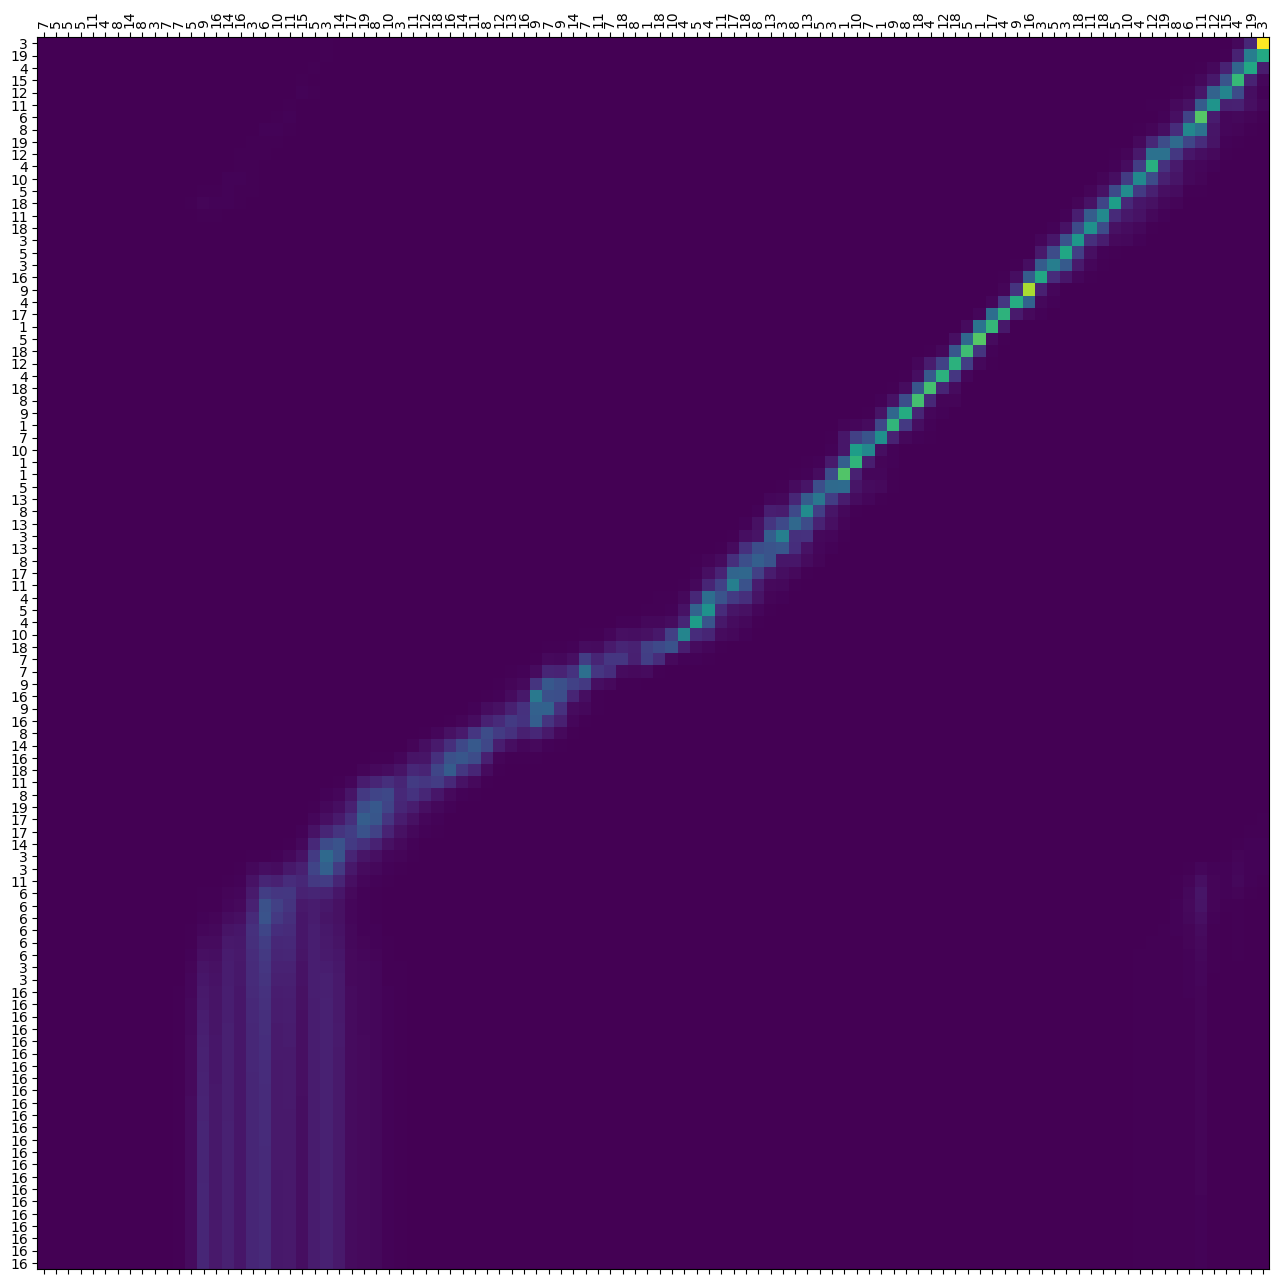

In [20]:
# LuongDot Attention
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_LD, decoder_lstm_LD, decoder_dense_LD, attention_LD)

<ipython-input-19-8a329c8a4881>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-19-8a329c8a4881>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


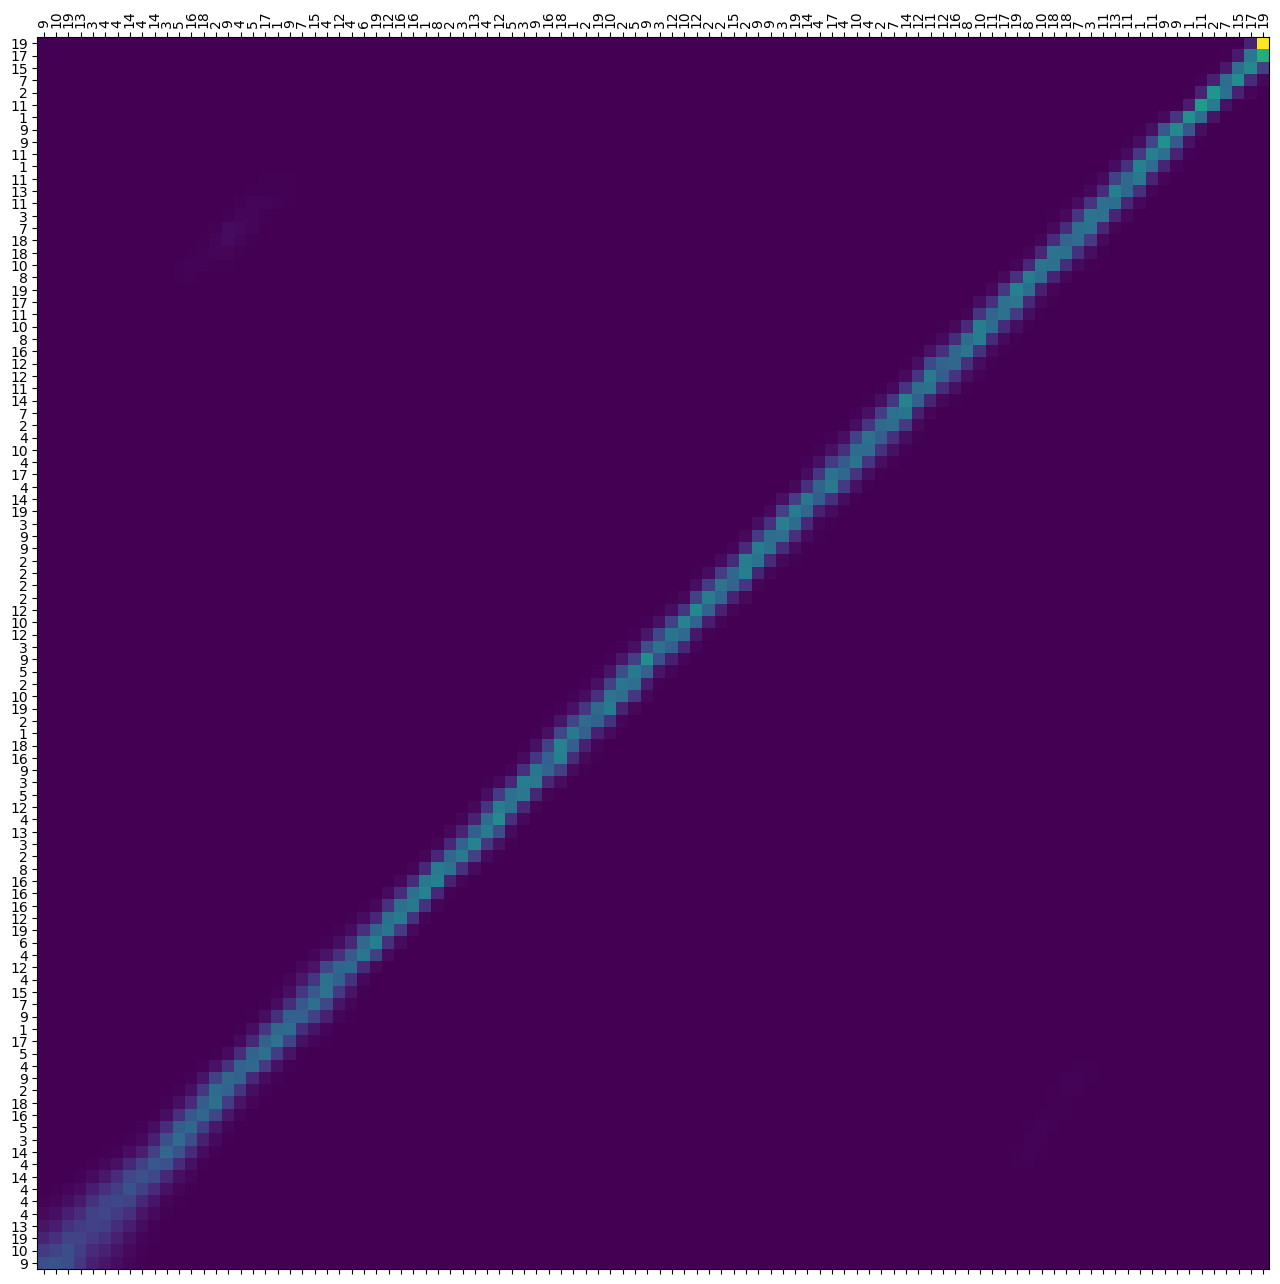

In [21]:
# Bahdanau Attention
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_B, decoder_lstm_B, decoder_dense_B, attention_B)

<ipython-input-7-8a329c8a4881>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-7-8a329c8a4881>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


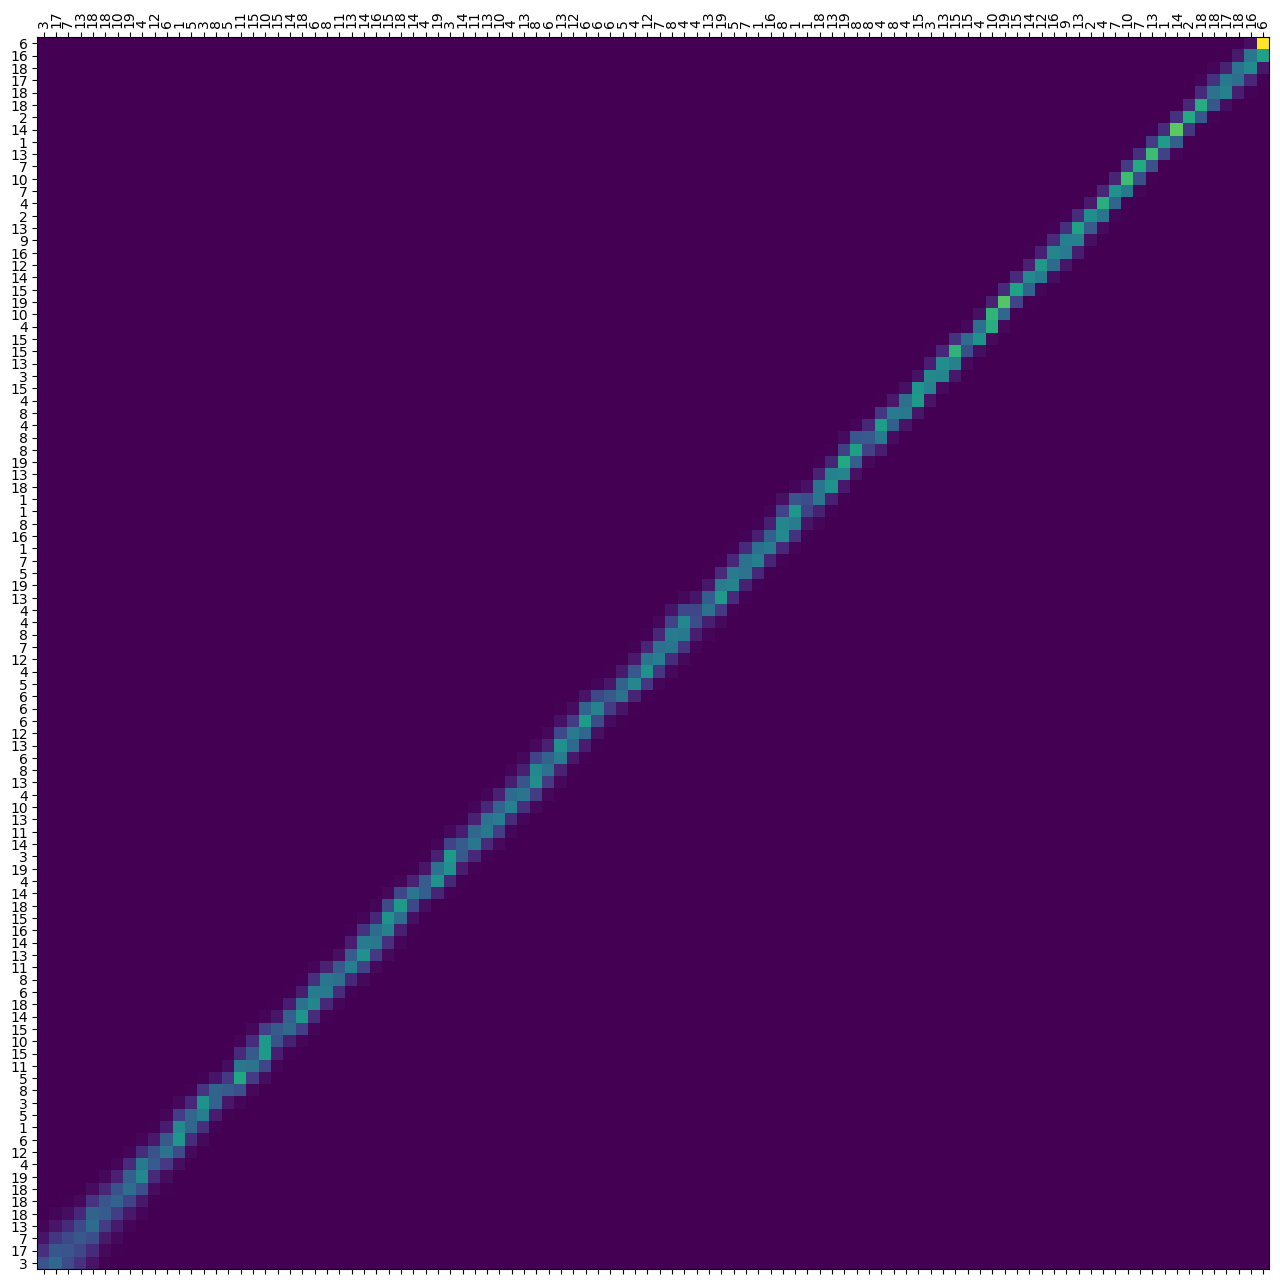

In [8]:
# Luong General Attention
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_LDG, decoder_lstm_LDG, decoder_dense_LDG, attention_LDG)

# Report

+ Bahdanau Attention and Luong General Attention implementation.

I implemented both the Bahdanau and Luong General attention by using their score metrics and their respective added weights for the TF layers. I followed the Bahdanau formula as:

$$
score(h_t, \overline{h}_s) = v_a^T\tanh(W_a[h_t;\overline{h}_s])
$$

And the Luong multiplicative (General) as:
$$
score(h_t, \overline{h}_s) = h_t^TW_a\overline{h}_s
$$

Then as both used the same base, I just needed to add their corresponding query modification, one with time one with just the values at $a$.
+ Comparative.
Between both the Bahdanau and General Luong I got approximately the same accuracies, with Bahdanau slightly on top. Both required long time to train but in general worked approximately the same in this toy problem, with the Luong being more computationally efficient due to it using a simpler approach to the score.

+ Weight visualization.

We see that in both the Bahdanau and the General Luong we keep approximately the same diagonal with their focus being predictable as the sequence continues. I couldn't quite compare them as they were using different datasets at a time.